### Google.colab
Only execute this cell when use on google colab platform (colab).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://github.com/Nak007/FeatureImportance">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Mount with google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/dirve')

# Import other libraries required.
!git clone 'http://github.com/Nak007/Calibration.git'

In [1]:
import pandas as pd, numpy as np, sys
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score
pd.options.display.float_format = '{:,.4f}'.format

from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.model_selection import train_test_split as tts
from sklearn.datasets import make_classification

try: sys.path.append('/content/Calibration')
except: pass
from Calibration import *

### <font color="green" size=5> Make classification data </font>

Generate a random n-class classification problem. [Reference](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)

In [2]:
X, y = make_classification(n_samples     = 10000, 
                           n_features    = 20, 
                           n_informative = 10, 
                           n_redundant   = 10, 
                           random_state  = 0, 
                           shuffle       = True, 
                           n_classes     = 2, 
                           weights       = [0.7,0.3])

X = pd.DataFrame(X, columns=["feature_" + str(n).zfill(2) 
                             for n in range(1,X.shape[1]+1)]) 

### <font color="green" size=5> Final classifier : retrain classifier (random_state, class_weight) </font>

Retrain model with new **_train_** & **_test_** sets, and **class_weight** and validate fitted model accordingly.

In [3]:
tts_kwds = {"test_size"   : 0.3,
            "random_state": 0, 
            "shuffle"     : True}
X_train, X_test, y_train, y_test = tts(X, y, **tts_kwds)

In [4]:
clf = rf(**{"random_state": 0, 
            "n_estimators": 50, 
            "n_jobs"      : -1, 
            "class_weight": "balanced", 
            "max_depth"   : 6, 
            "max_features": "sqrt"})

In [5]:
clf.fit(X_train, y_train)
y_train_proba = clf.predict_proba(X_train)[:,1]
y_test_proba  = clf.predict_proba(X_test )[:,1]

### <font color="green" size=5> Calibration of probability </font>

The purpose of calibration is to improve estimated probabilities, which can be directly interpreted as a confidence level. For instance a well calibrated (binary) classifier should classify the samples such that among the samples to which it gave a predict_proba value close to 0.8, approx. 80% actually belong to the positive class. The samples that are used to fit the calibrator should not be the same samples used to fit the classifier, as this would introduce bias. [Reference](https://scikit-learn.org/stable/modules/calibration.html) 

In [6]:
weights  = get_classweights(y=y)
y_scores = (y_test_proba.reshape(-1,1), y_train_proba.reshape(-1,1))

Using logistic regression as a calibrator, we are trying to find the optimal `class_weight` that yields the smallest difference of a given evaluation metric e.g. f1-score with a threshold of 0.5, between train and test datasets.

In [7]:
from sklearn.linear_model import LogisticRegression
scores = []
for w in weights:
    kwds = dict(max_iter=500, tol=1e-4, class_weight=w)
    calibrator = LogisticRegression(**kwds).fit(y_scores[0], y_test)
    scores.append([f1_score(y_true, calibrator.predict(y_scores[n])) 
                   for n,y_true in enumerate([y_test, y_train])]) 
    
small = np.argmin(np.diff(np.array(scores), axis=1))
print(f"The index of class weights is {small}.")

The index of class weights is 4.


Fit calibrator with selected `class_weight`.

In [8]:
kwds = dict(max_iter=500, tol=1e-4, class_weight=weights[small])
calibrator = LogisticRegression(**kwds).fit(y_scores[0], y_test)

Use **`CalibatorEvaluation`** to evaluate the calibrated probabilities.

In [9]:
train  = (y_test , calibrator.predict_proba(y_scores[0])[:,1])
test   = (y_train, calibrator.predict_proba(y_scores[1])[:,1])
calibr = CalibatorEvaluation(equal_width=False, bins=range(2,21)).fit(train, test)

Use **`plotting_metric()`** to observe how change in number of bins can affect evaluation metrics i.e. gini impurity (`gini`), and R-Squared (`r2`).

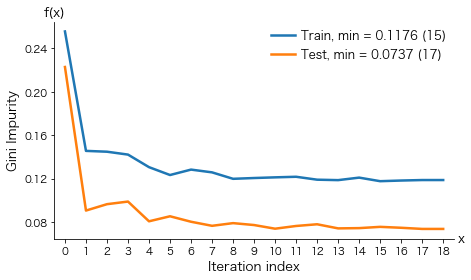

In [10]:
ax = calibr.plotting_metric("gini")

Use **`plotting_reliability()`** to plot calibration curve or so-called **reliability curve**.

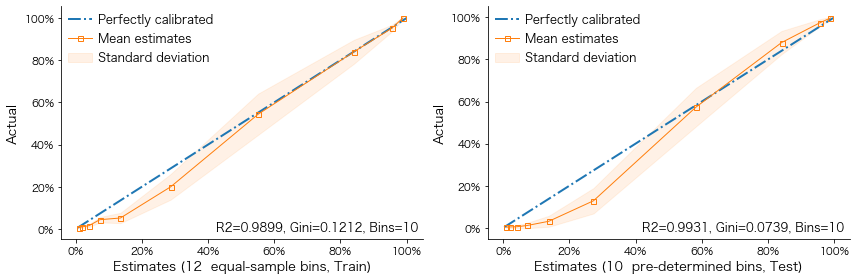

In [11]:
n_iter = 10
axes = plt.subplots(1,2,figsize=(12,4))[1]
ax = calibr.plotting_reliability(n_iter, use_train=True , ax=axes[0])
ax = calibr.plotting_reliability(n_iter, use_train=False, ax=axes[1])

Use **`plotting_hist()`** to enable us to compare calibrated estimates and actual percentage.

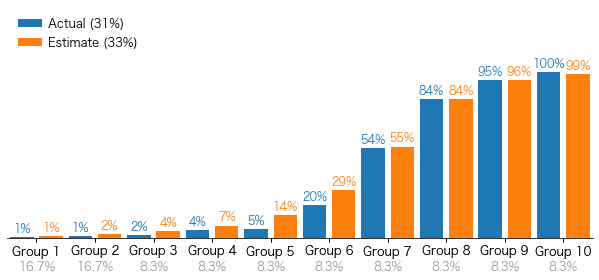

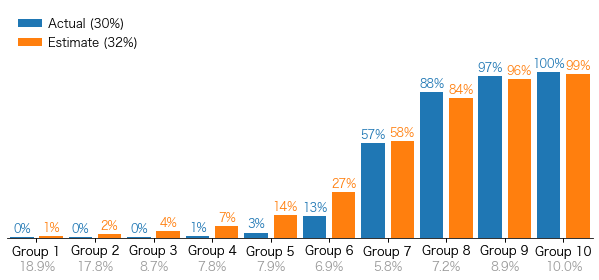

In [12]:
calibr.plotting_hist(n_iter, use_train=True ); plt.show()
calibr.plotting_hist(n_iter, use_train=False); plt.show()

Summary table

In [13]:
calibr.result[n_iter].train.info

,r_min,r_max,p_samples,min_proba,max_proba,mean_proba,std_proba,p_targets
0,0.0000,0.0132,0.1667,0.0053,0.0131,0.0090,0.0021,0.0060
1,0.0132,0.0312,0.1667,0.0132,0.0312,0.0203,0.0051,0.0100
2,0.0312,0.0540,0.0833,0.0312,0.0537,0.0408,0.0067,0.0160
3,0.0540,0.0980,0.0833,0.0542,0.0980,0.0730,0.0125,0.0440
4,0.0980,0.1868,0.0833,0.0980,0.1866,0.1353,0.0245,0.0520
5,0.1868,0.4025,0.0833,0.1872,0.4020,0.2872,0.0607,0.2000
6,0.4025,0.7311,0.0833,0.4035,0.7309,0.5515,0.0975,0.5440
7,0.7311,0.9207,0.0833,0.7319,0.9205,0.8409,0.0567,0.8400
8,0.9207,0.9786,0.0833,0.9214,0.9786,0.9558,0.0157,0.9520
9,0.9786,1.0000,0.0833,0.9787,0.9958,0.9887,0.0051,1.0000


Calibrate the estimates from initial estimator.

In [14]:
z = clf.predict_proba(X_train)[:,1] * calibrator.coef_ + calibrator.intercept_
estimates = 1/(1 + np.exp(-z))

Assign probabilities into groups with respect to `bin_edges`.

In [15]:
bin_edges   = calibr.result[n_iter].train.bin_edges
group_proba = np.digitize(estimates, bin_edges)

### <font color="green" size=5> Score </font>

Use **`cal_score()`** to convert probability into score.

In [16]:
p_min = 0.0001
score_kwds = dict(pdo=20, point=0, odd=p_min/(1-p_min))

In [17]:
final_group = pd.DataFrame(calibr.result[n_iter].train.info)
final_group["min_score"] = cal_score(final_group["r_min"], **score_kwds).astype(int)
final_group["max_score"] = cal_score(final_group["r_max"], **score_kwds).astype(int)
final_group["group"] = np.arange(1, len(final_group)+1)
scores = cal_score(estimates, **score_kwds).astype(int)

In [18]:
final_group.set_index("group")

,r_min,r_max,p_samples,min_proba,max_proba,mean_proba,std_proba,p_targets,min_score,max_score
group,,,,,,,,,,
1,0.0000,0.0132,0.1667,0.0053,0.0131,0.0090,0.0021,0.0060,0,141
2,0.0132,0.0312,0.1667,0.0132,0.0312,0.0203,0.0051,0.0100,141,167
3,0.0312,0.0540,0.0833,0.0312,0.0537,0.0408,0.0067,0.0160,167,183
4,0.0540,0.0980,0.0833,0.0542,0.0980,0.0730,0.0125,0.0440,183,202
5,0.0980,0.1868,0.0833,0.0980,0.1866,0.1353,0.0245,0.0520,202,223
6,0.1868,0.4025,0.0833,0.1872,0.4020,0.2872,0.0607,0.2000,223,254
7,0.4025,0.7311,0.0833,0.4035,0.7309,0.5515,0.0975,0.5440,254,295
8,0.7311,0.9207,0.0833,0.7319,0.9205,0.8409,0.0567,0.8400,295,336
9,0.9207,0.9786,0.0833,0.9214,0.9786,0.9558,0.0157,0.9520,336,376
